In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

In [2]:

from plotting import *
plt.style.use('dark_background')
from tqdm.notebook import trange, tqdm

In [3]:
from rbfNet import *

<IPython.core.display.Javascript object>


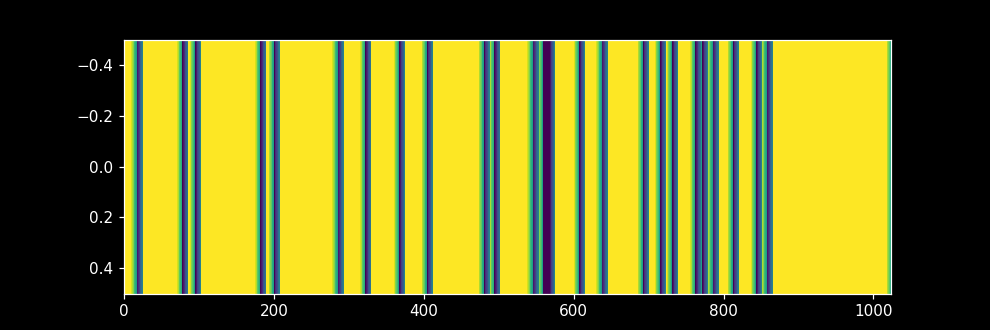

In [4]:
training, validation, counter = getSamples(1024, maxRollOut = 8, chunked = True, trainValidationSplit = 0.8, limitRollOut = False)

fig, axis = plt.subplots(1,1, figsize=(9,3), sharex = True, sharey = False, squeeze = False)

axis[0,0].imshow(counter[None,:], aspect='auto', interpolation='nearest')

In [5]:
print('a')

a


In [6]:
basePath = '../export'
basePath = os.path.expanduser(basePath)

simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.hdf5')]
# for i, c in enumerate(simulationFiles):
#     print(i ,c)
#     
simulationFiles  = [simulationFiles[0]]

training = []
validation = []
testing = []


for s in simulationFiles:    
    _, train, valid, test = splitFile(s, split = True, limitRollOut = False, skip = 0, cutoff = 800, distance = 16)
    training.append((s,train))
    validation.append((s,valid))
    testing.append((s,test))

In [7]:
debugPrint(training)

training [list] = [('../export/collision 2 x 1 - 2023-02-17_10-59-48.hdf5', (array([   0,   16,   32,   48,   64,   80,   96,  112,  128,  144,  160,
        176,  192,  208,  224,  240,  256,  272,  288,  304,  320,  336,
        352,  368,  384,  400,  416,  432,  576,  592,  608,  624,  640,
        656,  672,  688,  704,  720,  736,  752,  768,  784,  800,  816,
        832,  848,  864,  880,  896,  912,  928,  944,  960,  976,  992,
       1008, 1024, 1040, 1056, 1072, 1088, 1104, 1120, 1136, 1152, 1168,
       1184, 1200, 1216, 1232, 1248, 1264, 1280, 1296, 1312, 1328, 1344,
       1360, 1376, 1392, 1536, 1552, 1568, 1584, 1600, 1616, 1632, 1648,
       1664, 1680, 1696, 1712, 1728, 1744, 1760]), array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7,
       6, 5, 4, 3, 2, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 7, 6, 5, 4, 3, 2, 1, 8, 8, 8, 8, 8, 8, 8,

In [5]:
batch_size = 4

train_ds = datasetLoader(training)
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size = batch_size).batch_sampler

validation_ds = datasetLoader(validation)
validation_dataloader = DataLoader(validation_ds, shuffle=True, batch_size = batch_size).batch_sampler

fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# frameIndex = 750
attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 400, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

debugPrint(fluidFeatures.shape)


n = 8
m = 8
coordinateMapping = 'polar'
windowFn = lambda r: torch.clamp(torch.pow(1. - r, 4) * (1.0 + 4.0 * r), min = 0)
rbf_x = 'linear'
rbf_y = 'linear'
initialLR = 1e-2
maxRollOut = 10
epochs = 25
frameDistance = 0




model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1], coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = 64)



lr = initialLR
optimizer = Adam(model.parameters(), lr=lr)
model = model.to(device)

# torch.max(getLoss(simulationFiles[0], state['timestep'], prediction, config, state, loss = 'preShift'))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters', count_parameters(model))

# with torch.no_grad():
#     model.convs[0].weight[:] = torch.normal(mean = torch.ones(model.convs[0].weight.shape),  std = 1e-4)
#     model.convs[1].weight[:] = torch.normal(mean = torch.ones(model.convs[1].weight.shape),  std = 1e-4)

        
optimizer.zero_grad()
model.train()

hyperParameterDict = {}
hyperParameterDict['n'] = n
hyperParameterDict['m'] = m
hyperParameterDict['coordinateMapping'] = coordinateMapping
hyperParameterDict['rbf_x'] = rbf_x
hyperParameterDict['rbf_y'] = rbf_y
hyperParameterDict['windowFunction'] = 'yes' if windowFn is not None else 'no'
hyperParameterDict['initialLR'] = initialLR
hyperParameterDict['maxRollOut'] = maxRollOut
hyperParameterDict['epochs'] = epochs
hyperParameterDict['frameDistance'] = frameDistance
hyperParameterDict['parameters'] =  count_parameters(model)

# debugPrint(hyperParameterDict)


timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
networkPrefix = 'RbfNet'

exportString = '%s - n=[%2d,%2d] rbf=[%s,%s] map = %s window = %s d = %2d e = %2d - %s' % (networkPrefix, hyperParameterDict['n'], hyperParameterDict['m'], hyperParameterDict['rbf_x'], hyperParameterDict['rbf_y'], hyperParameterDict['coordinateMapping'], hyperParameterDict['windowFunction'], hyperParameterDict['frameDistance'], hyperParameterDict['epochs'], timestamp)


# # exportPath = './trainingData/%s - %s.hdf5' %(self.config['export']['prefix'], timestamp)
# if not os.path.exists('./trainingData/%s' % exportString):
#     os.makedirs('./trainingData/%s' % exportString)
# # self.outFile = h5py.File(self.exportPath,'w')


fluidFeatures.shape [Size] = torch.Size([802, 5])
Number of parameters 688416


In [6]:
model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes).shape

torch.Size([802, 2])

In [10]:

def processBatch(model, device, li, attributes, e, unroll, train_ds, bdata, frameDistance):
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidBatches, boundaryBatches, groundTruths = loadBatch(train_ds, bdata, constructFluidFeatures, unroll, frameDistance)    
    

    predictedPositions = fluidPositions.to(device)
    predictedVelocity = fluidFeatures[:,1:3].to(device)
    
    bLosses = []
    boundaryPositions = boundaryPositions.to(device)
    fluidFeatures = fluidFeatures.to(device)
    boundaryFeatures = boundaryFeatures.to(device)
    fluidBatches = fluidBatches.to(device)
    boundaryBatches = boundaryBatches.to(device)
            
    for u in range(unroll):
        predictions = model(predictedPositions, boundaryPositions, fluidFeatures, boundaryFeatures, attributes, fluidBatches, boundaryBatches)
        predictedPositions, predictedVelocities = integrateState(attributes, predictedPositions, predictedVelocity, predictions)        
        fluidFeatures = torch.hstack((fluidFeatures[:,0][:,None], predictedVelocity, fluidFeatures[:,3:]))
                
        if li:
            loss = model.li * computeLoss(predictedPositions, predictedVelocities, groundTruths[u].to(device), predictions)
        else:
            loss = computeLoss(predictedPositions, predictedVelocities, groundTruths[u].to(device), predictions)

        batchedLoss = []
        for i in range(len(bdata)):
            L = loss[fluidBatches == i]
            Lterms = (torch.mean(L), torch.max(torch.abs(L)), torch.min(torch.abs(L)), torch.std(L))            
            batchedLoss.append(torch.hstack(Lterms))
        batchedLoss = torch.vstack(batchedLoss).unsqueeze(0)
        bLosses.append(batchedLoss)
    
    bLosses = torch.vstack(bLosses)
    maxLosses = torch.max(bLosses[:,:,1], dim = 0)[0]
    minLosses = torch.min(bLosses[:,:,2], dim = 0)[0]
    meanLosses = torch.mean(bLosses[:,:,0], dim = 0)
    stdLosses = torch.mean(bLosses[:,:,3], dim = 0)
    
    
    del predictedPositions, predictedVelocities, boundaryPositions, fluidFeatures, boundaryFeatures, fluidBatches, boundaryBatches
    
    bLosses = bLosses.transpose(0,1)
    
    return bLosses, meanLosses, minLosses, maxLosses, stdLosses




In [22]:

te = tqdm(range(epochs))
t = tqdm(train_dataloader)

#         t.set_description('%3d [%5d x %5d] @ %1.5e: %1.5e' %(epoch, bdata[0], rollout, lr, sumLosses))
#         t.update()
# #         break
rollout = 4
epochLosses = []

def processDataLoader(ds, dataLoader, model, optimizer, t, train = True, prefix = ''):
    t.reset(total=len(dataLoader))
    losses = []
    batchIndices = []
    
    if train:
        model.train(True)
    else:
        model.train(False)
    
    for bdata in dataLoader:
        if train:
            optimizer.zero_grad()
        
#         debugPrint(bdata)
        batchLosses, meanLosses, minLosses, maxLosses, stdLosses = processBatch(ds, bdata,  1)
        
#         debugPrint(batchLosses)
#         sumLosses = processBatch(bdata,  1)
        batchIndices.append(np.array(bdata))
        losses.append(batchLosses.detach().cpu().numpy())
        
        sumLosses = torch.mean(batchLosses[:,:,0])
        sumLosses.backward()
        if train:
            optimizer.step()
#         debugPrint(sumLosses)
#         debugPrint(meanLosses)
    
        lossString = np.array2string(meanLosses.detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.4e" % x})
        batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))
        
#         debugPrint(batchString)
        
        t.set_description('%24s: %3d [%5d] @ %1.5e: %s - %s -> %.4e' %(prefix, e, rollout, lr, batchString, lossString, sumLosses.detach().cpu().numpy()))
#         t.set_description('%3d [%5d] @ %1.5e: %d - %.4e' %(e, rollout, lr, bdata[0], sumLosses.detach().cpu().numpy()))
        t.update()
    bIndices  = np.hstack(batchIndices)
    losses = np.vstack(losses)

    idx = np.argsort(bIndices)
    bIndices = bIndices[idx]
    losses = losses[idx]

    epochLoss = losses
#     epochLosses.append(epochLoss)
    return epochLoss

trainingEpochLosses = []
trainingEpochLosses2 = []
validationLosses = []

for e in te:
    t.reset(total=len(train_dataloader))
    losses = []
    trainingEpochLoss = processDataLoader(train_ds, train_dataloader, model, optimizer, t, True, prefix = 'training')
    trainingEpochLosses.append(trainingEpochLoss)
#     trainingEpochLoss2 = processDataLoader(train_dataloader, model, optimizer, t, False, prefix = 'training')
#     trainingEpochLosses2.append(trainingEpochLoss2)
    validationEpochLoss = processDataLoader(validation_ds, validation_dataloader, model, optimizer, t, False, prefix = 'validation')
    validationLosses.append(validationEpochLoss)
    
    
    torch.save(model.state_dict(), './trainingData/%s/model_%03d.json' % (exportString, e))
#     batchIndices = []
#     for bdata in train_dataloader:
#         optimizer.zero_grad()
        
#         batchLosses, meanLosses, minLosses, maxLosses, stdLosses = processBatch(bdata,  1)
        
# #         debugPrint(batchLosses)
# #         sumLosses = processBatch(bdata,  1)
#         batchIndices.append(np.array(bdata))
#         losses.append(batchLosses.detach().cpu().numpy())
        
#         sumLosses = torch.mean(batchLosses[:,:,0])
#         sumLosses.backward()

#         optimizer.step()
# #         debugPrint(batchLosses)
# #         debugPrint(meanLosses)
    
#         lossString = np.array2string(meanLosses.detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.4e" % x})
#         batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))
        
# #         debugPrint(batchString)
        
#         t.set_description('%3d [%5d] @ %1.5e: %s - %s -> %.4e' %(e, rollout, lr, batchString, lossString, sumLosses.detach().cpu().numpy()))
# #         t.set_description('%3d [%5d] @ %1.5e: %d - %.4e' %(e, rollout, lr, bdata[0], sumLosses.detach().cpu().numpy()))
#         t.update()
#     bIndices  = np.hstack(batchIndices)
#     losses = np.vstack(losses)

#     idx = np.argsort(bIndices)
#     bIndices = bIndices[idx]
#     losses = losses[idx]

#     epochLoss = losses
#     epochLosses.append(epochLoss)

#         break
    if e % 1 == 0:
        lr = lr * 0.9
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.9 * param_group['lr']
#     break
        
        

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

In [23]:
train_ds[0]

trainDict = {}
for i in range(len(train_ds)):
    fileName, index, _ = train_ds[i]
    trainDict['%05d' % i] = {'file':fileName, 't':int( index)}
#     break
validationDict = {}
for i in range(len(validation_ds)):
    fileName, index, _ = validation_ds[i]
    validationDict['%05d' % i] = {'file':fileName, 't': int(index)}
#     break
    
dataSetDict = {'training' : trainDict, 'validation': validationDict}

In [43]:
debugPrint(np.mean(np.mean(trainingEpochLoss[:,:,0], axis = 1)))

np.mean(np.mean(trainingEpochLoss[:,:,0], axis = 1)) [float32] = 0.0006533423438668251


In [36]:
# simulationFiles

In [25]:
import json
from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [26]:
dataDict = {}

for e in range(len(validationLosses)):
    dataDict['%03d' % (e+1)] = {"validation": validationLosses[0], "training": trainingEpochLosses[0]}
#     break

modelData = {'hyperParameters' : hyperParameterDict, 'dataSet': dataSetDict, 'epochData': dataDict, 'files': simulationFiles}



encodedNumpyData = json.dumps(modelData, cls=NumpyArrayEncoder, indent=4) 
with open('./trainingData/%s/results.json' % exportString, "w") as write_file:
    json.dump(modelData, write_file, cls=NumpyArrayEncoder, indent=4) 


In [27]:
# debugPrint(encodedNumpyData)

In [28]:

def plotLossesv2(epochLosses, logScale = True):
    overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in epochLosses])
    indices = np.arange(overallLosses.shape[1])

    fig, axis = plt.subplots(3, 4, figsize=(16,12), sharex = False, sharey = False, squeeze = False)

    axis[1,0].set_yscale('log')
    axis[1,1].set_yscale('log')
    axis[1,2].set_yscale('log')
    axis[1,3].set_yscale('log')
    axis[1,0].set_xlabel('index')
    axis[1,1].set_xlabel('index')
    axis[1,2].set_xlabel('index')
    axis[1,3].set_xlabel('index')
    axis[1,0].set_ylabel('Loss')

    axis[0,0].set_xlabel('epoch')
    axis[0,1].set_xlabel('epoch')
    axis[0,2].set_xlabel('epoch')
    axis[0,3].set_xlabel('epoch')
    axis[0,0].set_ylabel('Loss')

    
    
    axis[2,0].set_xlabel('epoch')
    axis[2,1].set_xlabel('epoch')
    axis[2,2].set_xlabel('epoch')
    axis[2,3].set_xlabel('epoch')
    axis[2,0].set_ylabel('index')

    axis[0,0].set_title('mean Loss')
    axis[0,1].set_title('max Loss')
    axis[0,2].set_title('min Loss')
    axis[0,3].set_title('std dev Loss')
    if logScale:
        axis[0,0].set_yscale('log')
        axis[0,1].set_yscale('log')
        axis[0,2].set_yscale('log')
        axis[0,3].set_yscale('log')
    
    
#     axis[0,0].grid(axis='y', which='both', alpha = 0.5)
#     axis[0,1].grid(axis='y', which='both', alpha = 0.5)
#     axis[0,2].grid(axis='y', which='both', alpha = 0.5)
#     axis[0,3].grid(axis='y', which='both', alpha = 0.5)
    
#     axis[1,0].grid(axis='y', which='both', alpha = 0.5)
#     axis[1,1].grid(axis='y', which='both', alpha = 0.5)
#     axis[1,2].grid(axis='y', which='both', alpha = 0.5)
#     axis[1,3].grid(axis='y', which='both', alpha = 0.5)
    
    
    
    for e in range(overallLosses.shape[0]):
#         axis[0,0].scatter(np.ones_like(indices) * e, overallLosses[e,:,0] ,label = '%d' % e, s = 0.25, c = indices, vmin = 0, vmax = np.max(indices), alpha = 0.75)
#         axis[0,1].scatter(np.ones_like(indices) * e, overallLosses[e,:,1] ,label = '%d' % e, s = 0.25, c = indices, vmin = 0, vmax = np.max(indices), alpha = 0.75)
#         axis[0,2].scatter(np.ones_like(indices) * e, overallLosses[e,:,2] ,label = '%d' % e, s = 0.25, c = indices, vmin = 0, vmax = np.max(indices), alpha = 0.75)
#         sc = axis[0,3].scatter(np.ones_like(indices) * e, overallLosses[e,:,3] ,label = '%d' % e, s = 0.25, c = indices, vmin = 0, vmax = np.max(indices), alpha = 0.75)
        axis[1,0].plot(indices, overallLosses[e,:,0] ,label = '%d' % e, c =  cm.viridis(e / overallLosses.shape[0]), alpha = 0.5)
        axis[1,1].plot(indices, overallLosses[e,:,1] ,label = '%d' % e,  c = cm.viridis(e / overallLosses.shape[0]), alpha = 0.5)
        axis[1,2].plot(indices, overallLosses[e,:,2] ,label = '%d' % e, c = cm.viridis(e / overallLosses.shape[0]), alpha = 0.5)
        pl = axis[1,3].plot(indices, overallLosses[e,:,3] ,label = '%d' % e,  c =cm.viridis( e / overallLosses.shape[0]), alpha = 0.5)

#     ax1_divider = make_axes_locatable(axis[0,3])
#     cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
#     cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
#     cbar.ax.tick_params(labelsize=8) 
#     cbar.set_alpha(1)
#     cbar.set_label('index')
#     cbar.solids.set(alpha=1)


    histPlot(fig, axis[0,0], overallLosses[:,:,0], xLabel = 'epoch', yLabel = 'Loss', logScale = logScale)
    histPlot(fig, axis[0,1], overallLosses[:,:,1], xLabel = 'epoch', logScale = logScale)
    histPlot(fig, axis[0,2], overallLosses[:,:,2], xLabel = 'epoch', logScale = logScale)
    histPlot(fig, axis[0,3], overallLosses[:,:,3], xLabel = 'epoch', logScale = logScale)
    
    ax1_divider = make_axes_locatable(axis[1,3])
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")

    cbar = mpl.colorbar.ColorbarBase(cax1,orientation='vertical', norm=mpl.colors.Normalize(vmin=0, vmax=25))
    cbar.ax.tick_params(labelsize=8) 
    cbar.set_label('epoch')

    im = axis[2,0].imshow(overallLosses[:,:,0].transpose(), norm=LogNorm(vmin=np.min(overallLosses[:,:,0][overallLosses[:,:,0] > 0]), vmax=np.max(overallLosses[:,:,0])))
    axis[2,0].axis('auto')
    ax1_divider = make_axes_locatable(axis[2,0])
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    cbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 

    im = axis[2,1].imshow(overallLosses[:,:,1].transpose(), norm=LogNorm(vmin=np.min(overallLosses[:,:,1][overallLosses[:,:,1] > 0]), vmax=np.max(overallLosses[:,:,1])))
    axis[2,1].axis('auto')
    ax1_divider = make_axes_locatable(axis[2,1])
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    cbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 

    im = axis[2,2].imshow(overallLosses[:,:,2].transpose(), norm=LogNorm(vmin=np.min(overallLosses[:,:,2][overallLosses[:,:,2] > 0]), vmax=np.max(overallLosses[:,:,2])))
    axis[2,2].axis('auto')
    ax1_divider = make_axes_locatable(axis[2,2])
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    cbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 


    im = axis[2,3].imshow(overallLosses[:,:,3].transpose(), norm=LogNorm(vmin=np.min(overallLosses[:,:,3][overallLosses[:,:,3] > 0]), vmax=np.max(overallLosses[:,:,3])))
    axis[2,3].axis('auto')
    ax1_divider = make_axes_locatable(axis[2,3])
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    cbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    cbar.set_label('loss')

    fig.tight_layout()
    
    return fig, axis

In [29]:
# overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in validationLosses])

<IPython.core.display.Javascript object>


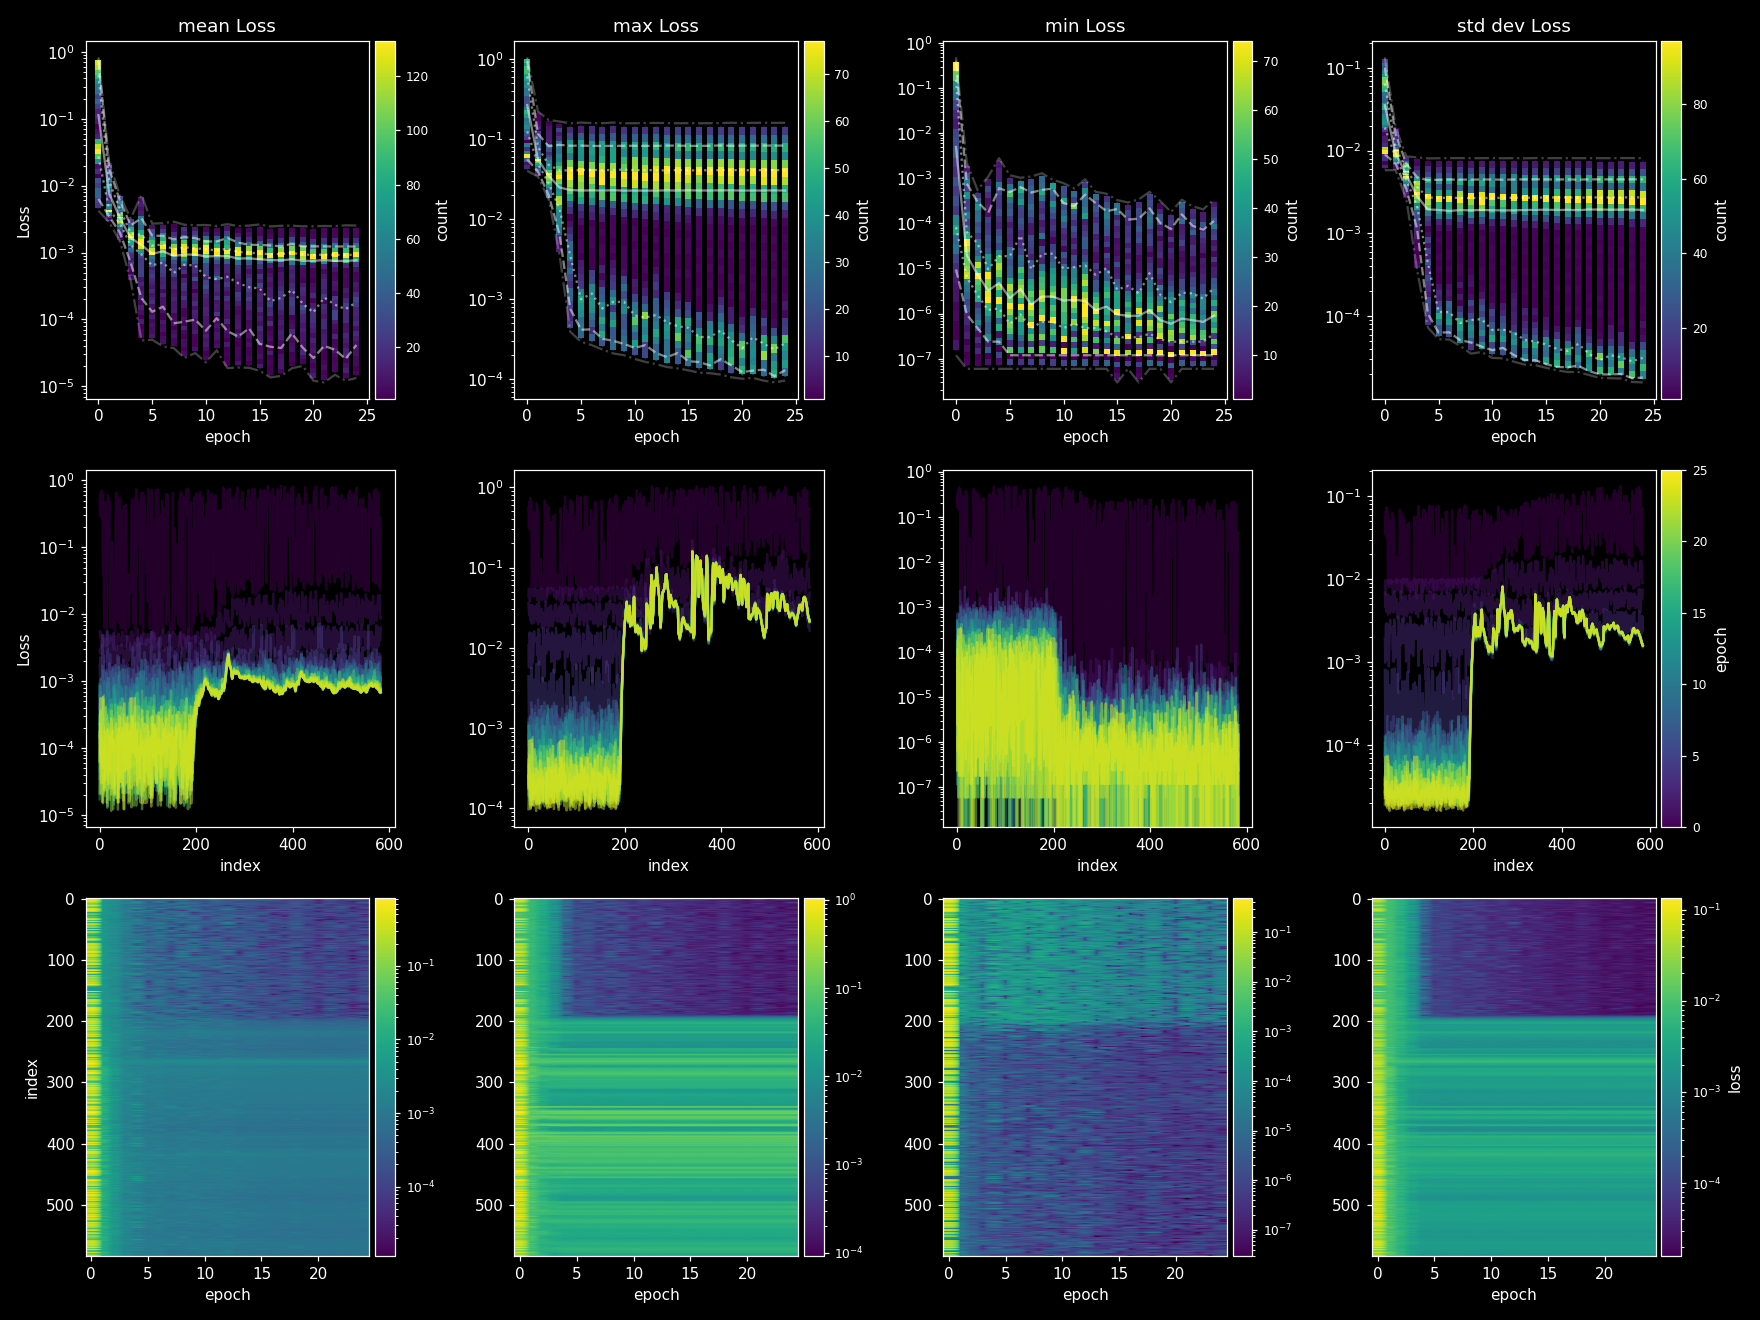

In [30]:
# plotLossesv2(trainingEpochLosses, logScale = True)
fig, axis = plotLossesv2(trainingEpochLosses, logScale = True)

fig.savefig('./trainingData/%s/training.png' % exportString, dpi = 300)

<IPython.core.display.Javascript object>


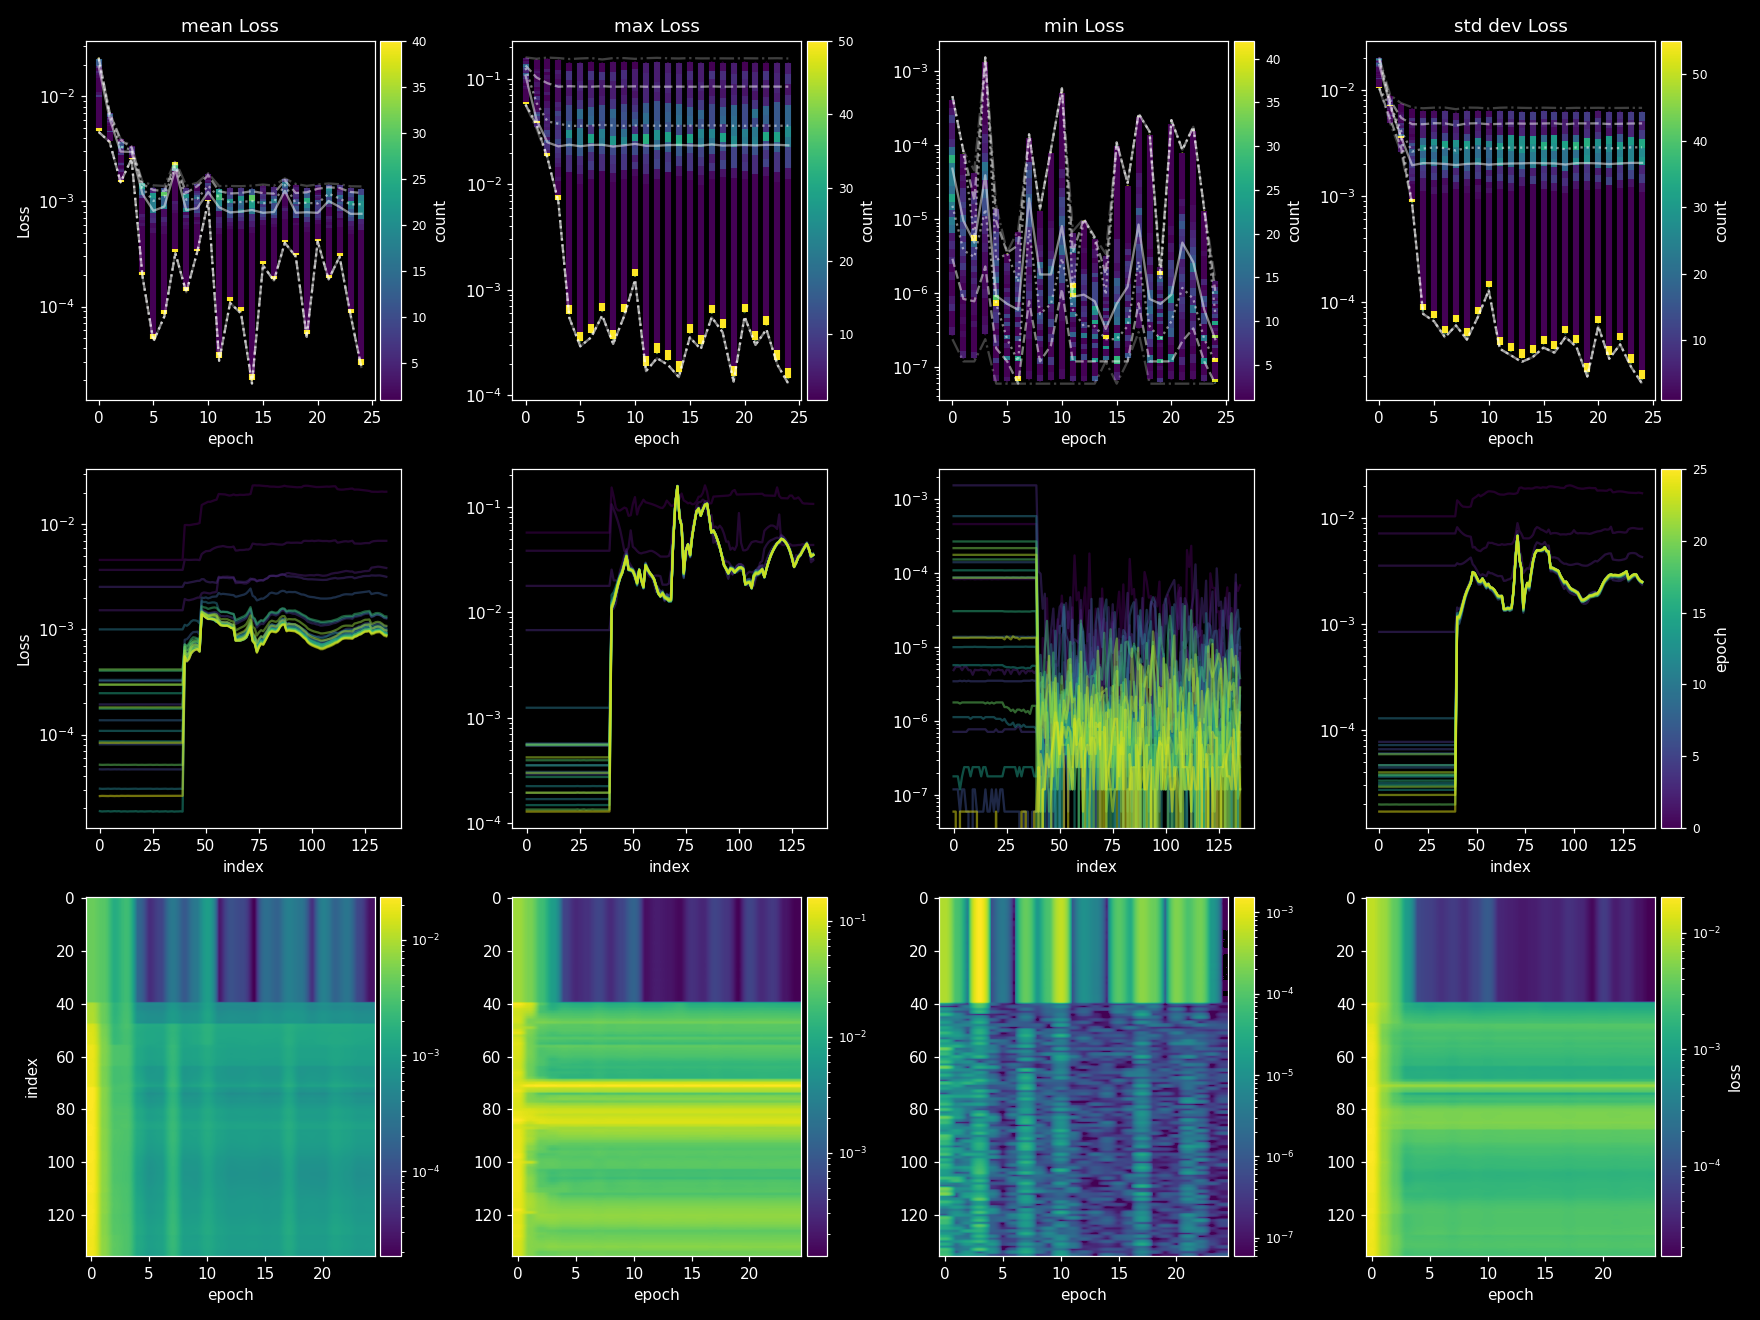

In [31]:

plotLossesv2(validationLosses, logScale = True)
fig.savefig('./trainingData/%s/validation.png' % exportString, dpi = 300)

In [32]:
import seaborn as sns
import pandas as pd

In [33]:
# debugPrint(epochLosses)

<IPython.core.display.Javascript object>


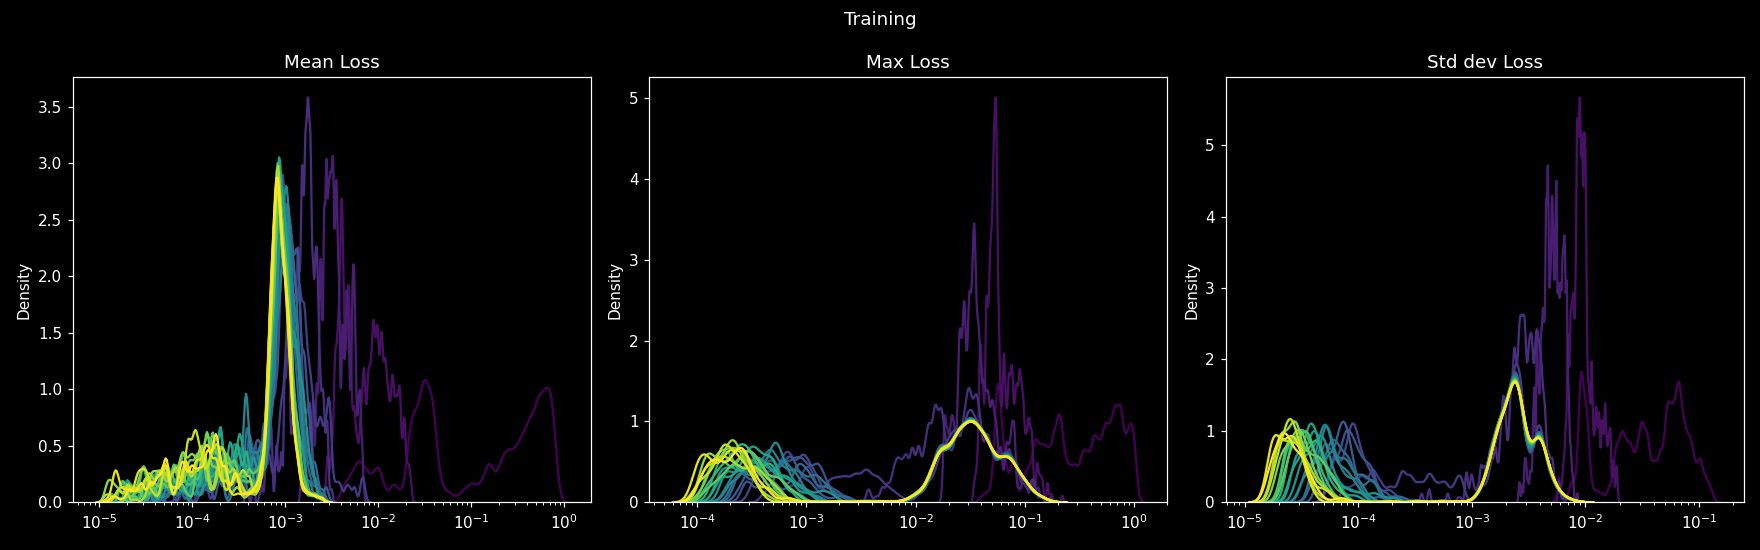

In [34]:
ei = -1
# epochLoss = {'mean': overallLosses[ei,:,0], 'max': overallLosses[ei,:,1], 'min': overallLosses[ei,:,1], 'stddev': overallLosses[ei,:,1]}
# epochLoss = pd.DataFrame(data = epochLoss)

overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in trainingEpochLosses])
fig, axis = plt.subplots(1, 3, figsize=(16,5), sharex = False, sharey = False, squeeze = False)

fig.suptitle('Training')

plt.sca(axis[0,0])
axis[0,0].set_title('Mean Loss')
axis[0,1].set_title('Max Loss')
axis[0,2].set_title('Std dev Loss')

# debugPrint(epochLosses[0].shape)

# sns.kdeplot(epochLoss, x='mean', bw_adjust=.2, log_scale=True)

for ei in range(overallLosses.shape[0]):
#     epochLoss = {'mean': overallLosses[ei,:,0], 'max': overallLosses[ei,:,1], 'min': overallLosses[ei,:,1], 'stddev': overallLosses[ei,:,1]}
#     epochLoss = pd.DataFrame(data = epochLoss)
    plt.sca(axis[0,0])
    sns.kdeplot(overallLosses[ei,:,0], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))
    plt.sca(axis[0,1])
    sns.kdeplot(overallLosses[ei,:,1], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))
    plt.sca(axis[0,2])
    sns.kdeplot(overallLosses[ei,:,3], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))

# axis[0,0].legend()

fig.tight_layout()

fig.savefig('./trainingData/%s/training_kde.png' % exportString, dpi = 300)

<IPython.core.display.Javascript object>


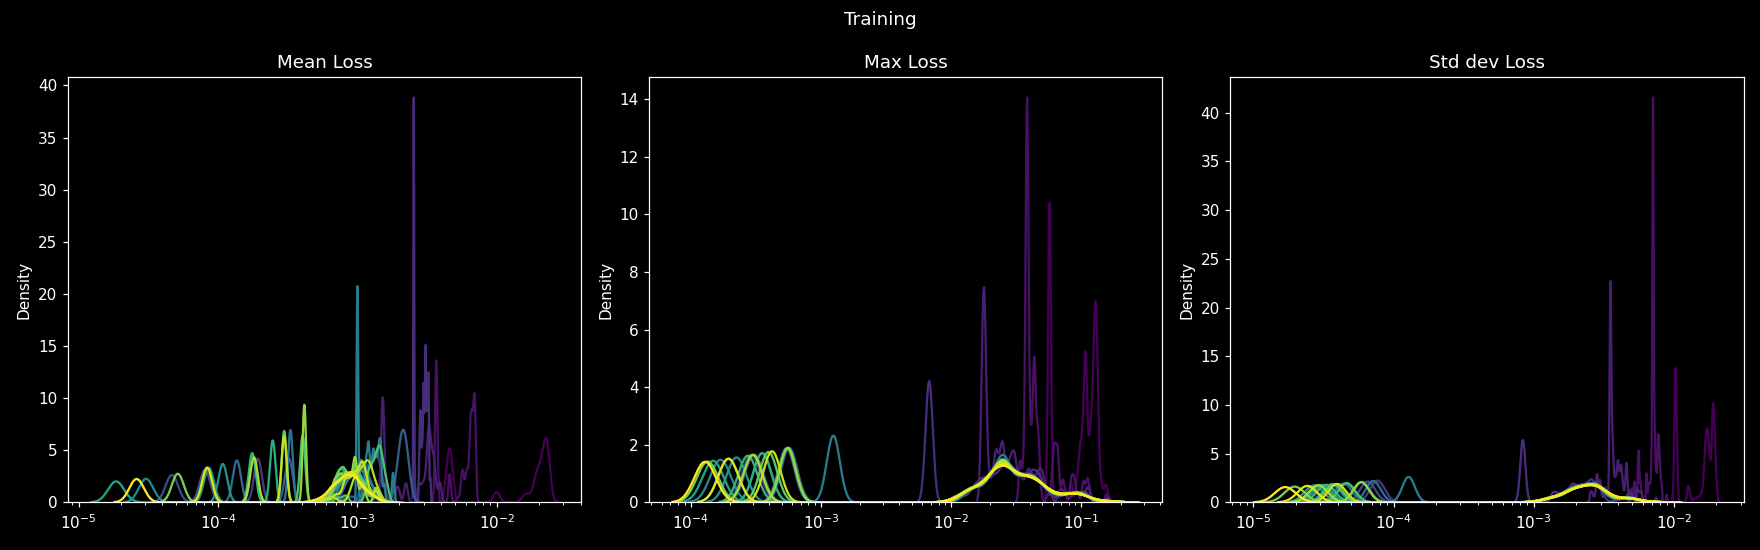

In [35]:
overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in validationLosses])
fig, axis = plt.subplots(1, 3, figsize=(16,5), sharex = False, sharey = False, squeeze = False)

fig.suptitle('Training')

plt.sca(axis[0,0])
axis[0,0].set_title('Mean Loss')
axis[0,1].set_title('Max Loss')
axis[0,2].set_title('Std dev Loss')

# debugPrint(epochLosses[0].shape)

# sns.kdeplot(epochLoss, x='mean', bw_adjust=.2, log_scale=True)

for ei in range(overallLosses.shape[0]):
#     epochLoss = {'mean': overallLosses[ei,:,0], 'max': overallLosses[ei,:,1], 'min': overallLosses[ei,:,1], 'stddev': overallLosses[ei,:,1]}
#     epochLoss = pd.DataFrame(data = epochLoss)
    plt.sca(axis[0,0])
    sns.kdeplot(overallLosses[ei,:,0], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))
    plt.sca(axis[0,1])
    sns.kdeplot(overallLosses[ei,:,1], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))
    plt.sca(axis[0,2])
    sns.kdeplot(overallLosses[ei,:,3], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))

# axis[0,0].legend()

fig.tight_layout()

fig.savefig('./trainingData/%s/validation_kde.png' % exportString, dpi = 300)

modelOutput.shape [Size] = torch.Size([802, 1])


<IPython.core.display.Javascript object>


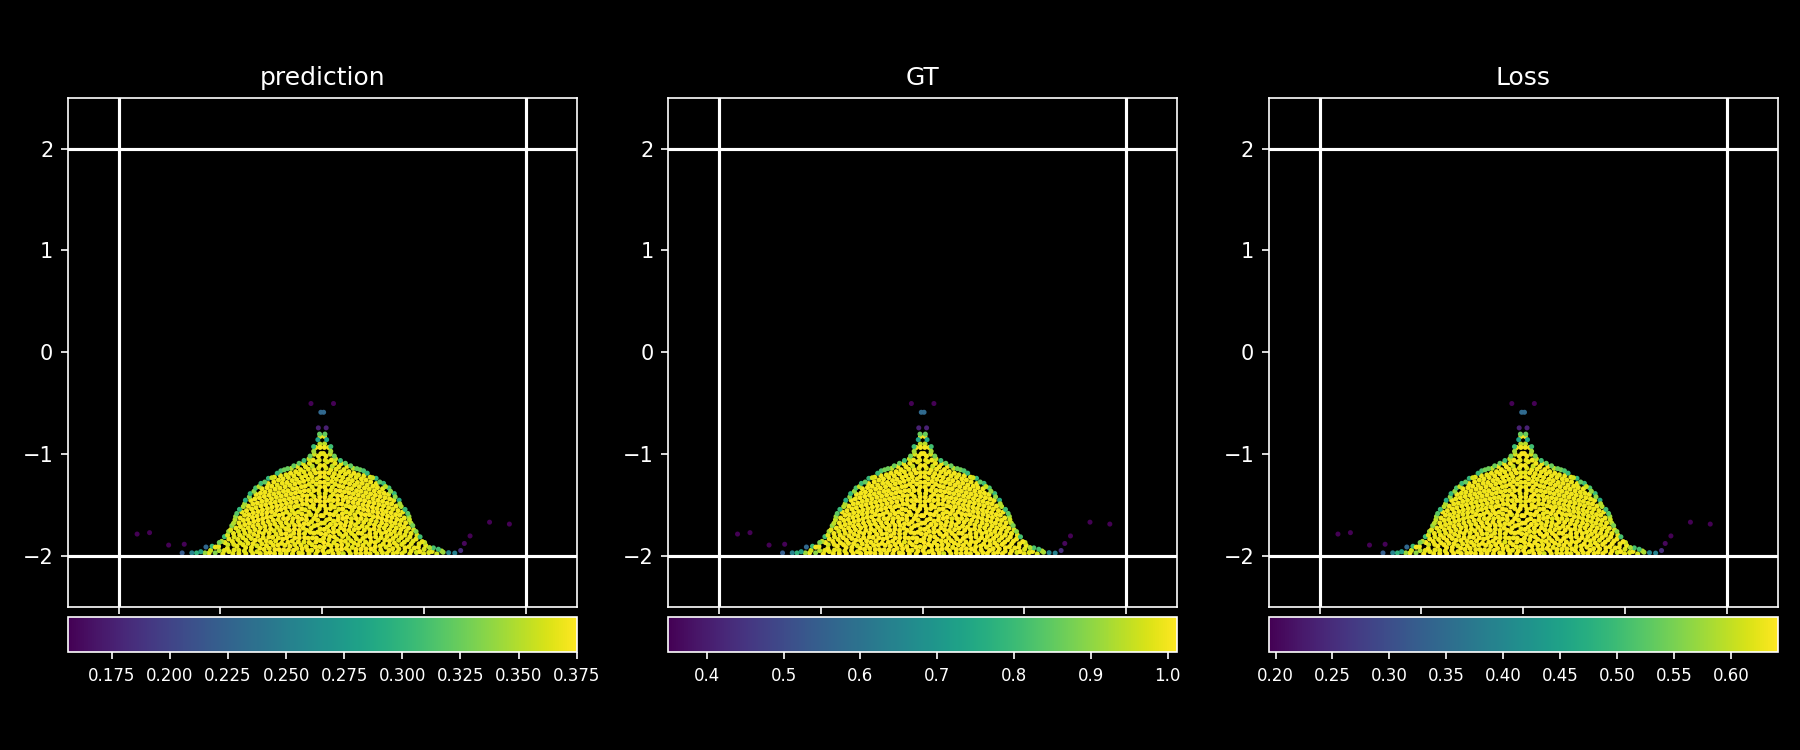

In [146]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# frameIndex = 750
attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 400, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)

debugPrint(modelOutput.shape)

positions = inputData['fluidPosition'].to(device)

predictedPosition = inputData['fluidPosition'] + attributes['dt'] * inputData['fluidVelocity']
predictedVelocity = inputData['fluidVelocity'].to(device)# +  modelOutput

gt = groundTruthData[0].type(torch.float32).to(device)

loss = computeLoss(predictedPosition, predictedVelocity, gt, modelOutput)# (gt[:,-1:] - modelOutput) ** 2


# print(state['time'])

fig, axis = plt.subplots(1, 3, figsize=(12,5), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('prediction')
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = modelOutput.detach().cpu().numpy()
# debugPrint(v)
predSC = axis[0,0].scatter(x,y,c = v,s=2)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-2.5,2.5)
axis[0,0].set_ylim(-2.5,2.5)
axis[0,0].axvline(-2)
axis[0,0].axvline(2)
axis[0,0].axhline(-2)
axis[0,0].axhline(2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")

predCbar = fig.colorbar(predSC, cax=cax1,orientation='horizontal')
predCbar.ax.tick_params(labelsize=8) 


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

# v = (gt[:,-1:] - modelOutput) ** 2
v = (gt[:,-1:] )

axis[0,1].set_title('GT')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,1].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-2.5,2.5)
axis[0,1].set_ylim(-2.5,2.5)
axis[0,1].axvline(-2)
axis[0,1].axvline(2)
axis[0,1].axhline(-2)
axis[0,1].axhline(2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()


axis[0,2].set_title('Loss')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,2].scatter(x,y,c = loss.detach().cpu().numpy(), s= 2)
axis[0,2].axis('equal')
axis[0,2].set_xlim(-2.5,2.5)
axis[0,2].set_ylim(-2.5,2.5)
axis[0,2].axvline(-2)
axis[0,2].axvline(2)
axis[0,2].axhline(-2)
axis[0,2].axhline(2)
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()



predictedPosition = inputData['fluidPosition'].to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)


In [232]:
# debugPrint(fluidFeatures)

In [46]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
frameIndex = 750
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)


positions = inputData['fluidPosition'].to(device)

predictedPosition = inputData['fluidPosition'] + attributes['dt'] * inputData['fluidVelocity']
predictedVelocity = inputData['fluidVelocity'].to(device)# +  modelOutput

gt = groundTruthData[0].type(torch.float32).to(device)

loss = torch.linalg.norm(gt[:,2:] - predictedVelocity, dim = 1) ** 2


# print(state['time'])

fig, axis = plt.subplots(1, 2, figsize=(9,5), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('prediction')
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(modelOutput,axis=1).detach().cpu().numpy()
# debugPrint(v)
predSC = axis[0,0].scatter(x,y,c = v,s=2)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-2.5,2.5)
axis[0,0].set_ylim(-2.5,2.5)
axis[0,0].axvline(-2)
axis[0,0].axvline(2)
axis[0,0].axhline(-2)
axis[0,0].axhline(2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")

predCbar = fig.colorbar(predSC, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

v = torch.linalg.norm(gt[:,2:] - predictedVelocity,axis=1).detach().cpu().numpy()

axis[0,1].set_title('Loss')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,1].scatter(x,y,c = v, s= 2)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-2.5,2.5)
axis[0,1].set_ylim(-2.5,2.5)
axis[0,1].axvline(-2)
axis[0,1].axvline(2)
axis[0,1].axhline(-2)
axis[0,1].axhline(2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='vertical')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()



predictedPosition = inputData['fluidPosition'].to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)


RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

In [141]:


# predictedPosition = inputData['fluidPosition'].to(device)
# predictedVelocity = inputData['fluidVelocity'].to(device)

for i in tqdm(range(128)):
#     debugPrint(i)
    fluidFeatures[:,1:3] = predictedVelocity
    
    modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)

    newPosition = predictedPosition + attributes['dt'] * predictedVelocity
    newVelocity = predictedVelocity +  modelOutput

    data = (torch.linalg.norm(modelOutput, dim = 1) ** 2).detach().cpu().numpy()
    data = (torch.linalg.norm(newVelocity, dim = 1) ** 2).detach().cpu().numpy()
    predCbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    predSC.set_offsets(newPosition.detach().cpu().numpy())
    predSC.set_array(data)

    attributes, inputData, groundTruthData = loadFrame(fileName,frameIndex + 1)
    data = (torch.linalg.norm(inputData['fluidPosition'].to(device) - newPosition, dim = 1) ** 2).detach().cpu().numpy()
    GTcbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    GTsc.set_offsets(inputData['fluidPosition'].detach().cpu().numpy())
    GTsc.set_array(data)

    predictedPosition = newPosition
    predictedVelocity = newVelocity
    fig.canvas.draw()
    fig.canvas.flush_events()

    frameIndex = frameIndex + 1
# for i in range(8):
#     modelOutput = model(predictedPosition, predictedVelocity, predictedPosition, attrs['support'], None, None)

#     predictedPosition = inputData['fluidPosition'] + attrs['dt'] * inputData['fluidVelocity']
#     predictedVelocity = inputData['fluidVelocity'].to(device) +  modelOutput

#     gt = gtData[0].type(torch.float32).to(device)
    
    
    

  0%|          | 0/128 [00:00<?, ?it/s]

In [80]:
def griepentrog(x,y):
    xMapped = torch.zeros_like(x)
    yMapped = torch.zeros_like(y)
    eps = 1e-7
    
    debugPrint(x.shape)
    debugPrint(y.shape)
    
    maskA = torch.logical_and(torch.abs(x) < eps, torch.abs(y) < eps)
    maskB = torch.logical_and(torch.abs(y) <= x, x > 0)
    maskC = torch.logical_and(torch.abs(y) <= -x, x < 0)
    maskD = torch.logical_and(torch.abs(x) <= y, y > 0)
    maskE = torch.logical_and(torch.abs(x) <= -y, y <0)
    
    debugPrint(torch.sum(maskA))
    debugPrint(torch.sum(maskB))
    debugPrint(torch.sum(maskC))
    debugPrint(torch.sum(maskD))
    debugPrint(torch.sum(maskE))
    debugPrint(torch.sum(maskA) + torch.sum(maskB) + torch.sum(maskC) + torch.sum(maskD) + torch.sum(maskE))
    
    xA = torch.zeros_like(x)
    yA = torch.zeros_like(y)
    
    xB = torch.sqrt(x**2 + y**2)
    yB = 4 / np.pi * torch.sqrt(x**2 + y**2) * torch.atan(y/x)
    
    xC = - xB
    yC = - yB
    
    xD = 4 / np.pi * torch.sqrt(x**2 + y**2) * torch.atan(x/y)
    yD = torch.sqrt(x**2+y**2)
    
    xE = -xD
    yE = -yD
    
    xMapped[maskA] = xA[maskA]
    xMapped[maskB] = xB[maskB]
    xMapped[maskC] = xC[maskC]
    xMapped[maskD] = xD[maskD]
    xMapped[maskE] = xE[maskE]
    
    yMapped[maskA] = yA[maskA]
    yMapped[maskB] = yB[maskB]
    yMapped[maskC] = yC[maskC]
    yMapped[maskD] = yD[maskD]
    yMapped[maskE] = yE[maskE]
    
    
    return xMapped, yMapped

x.shape [Size] = torch.Size([16129])
y.shape [Size] = torch.Size([16129])
torch.sum(maskA) [Tensor] = 1
torch.sum(maskB) [Tensor] = 4078
torch.sum(maskC) [Tensor] = 4093
torch.sum(maskD) [Tensor] = 4078
torch.sum(maskE) [Tensor] = 4093
torch.sum(maskA) + torch.sum(maskB) + torch.sum(maskC) + torch.sum(maskD) + torch.sum(maskE) [Tensor] = 16343
x.shape [Size] = torch.Size([16])
y.shape [Size] = torch.Size([16])
torch.sum(maskA) [Tensor] = 0
torch.sum(maskB) [Tensor] = 6
torch.sum(maskC) [Tensor] = 6
torch.sum(maskD) [Tensor] = 6
torch.sum(maskE) [Tensor] = 6
torch.sum(maskA) + torch.sum(maskB) + torch.sum(maskC) + torch.sum(maskD) + torch.sum(maskE) [Tensor] = 24


<IPython.core.display.Javascript object>


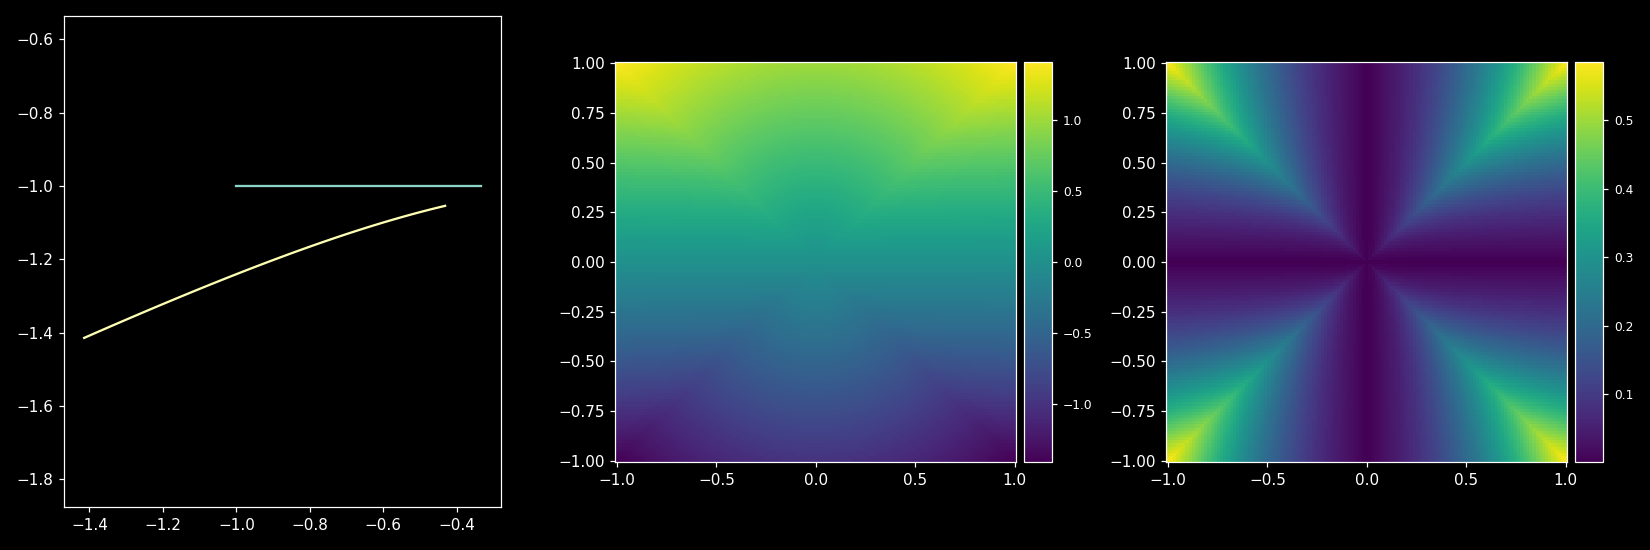

x.shape [Size] = torch.Size([127])
y.shape [Size] = torch.Size([127])
torch.sum(maskA) [Tensor] = 0
torch.sum(maskB) [Tensor] = 0
torch.sum(maskC) [Tensor] = 1
torch.sum(maskD) [Tensor] = 0
torch.sum(maskE) [Tensor] = 127
torch.sum(maskA) + torch.sum(maskB) + torch.sum(maskC) + torch.sum(maskD) + torch.sum(maskE) [Tensor] = 128


In [88]:
xMapped, yMapped = griepentrog(xxf,yyf)


xs = torch.linspace(-1,1,4)
ys = torch.linspace(-1,1,4)
xxs,yys = torch.meshgrid(xs,ys,indexing='xy')
xxfs = xxs.flatten()
yyfs = yys.flatten()
xsMapped, ysMapped = griepentrog(xxfs, yyfs)

fig, axis = plt.subplots(1, 3, figsize=(15,5), sharex = False, sharey = False, squeeze = False)

linex = torch.linspace(xxfs[0], xxfs[1], 127)
liney = torch.linspace(yyfs[0], yyfs[1], 127)
linexMapped, lineyMapped = griepentrog(linex, liney)

axis[0,0].plot(linex, liney)
axis[0,0].plot(linexMapped, lineyMapped)


# pc = axis[0,0].tripcolor(xxf,yyf, (cubePositions[:,0]))
# pc = axis[0,0].pcolormesh(xx,yy, (xMapped).reshape(xx.shape))
# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
# predCbar = fig.colorbar(pc, cax=cax1,orientation='vertical')
# predCbar.ax.tick_params(labelsize=8) 


# axis[0,0].scatter(xxfs, yyfs, c = 'blue')
# axis[0,0].scatter(xsMapped, ysMapped, c = 'blue')

axis[0,0].axis('equal')

# pc = axis[0,1].tripcolor(xxf,yyf, (cubePositions[:,1]))
pc = axis[0,1].pcolormesh(xx,yy, (yMapped).reshape(xx.shape))
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
predCbar = fig.colorbar(pc, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 
axis[0,1].axis('equal')

# pc = axis[0,2].tripcolor(xxf,yyf, torch.linalg.norm(positions - cubePositions, dim = 1))
pc = axis[0,2].pcolormesh(xx,yy, (torch.linalg.norm(positions - torch.vstack((xMapped,yMapped,torch.zeros_like(xMapped))).mT, dim = 1)).reshape(xx.shape))
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
predCbar = fig.colorbar(pc, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 
axis[0,2].axis('equal')

fig.tight_layout()

torch.min(cubePositions[mask,0]) [Tensor] = -0.9999998807907104
torch.min(cubePositions[mask,1]) [Tensor] = -0.9999998807907104
torch.max(cubePositions[mask,0]) [Tensor] = 0.9999998807907104
torch.max(cubePositions[mask,1]) [Tensor] = 0.9999998807907104


<IPython.core.display.Javascript object>


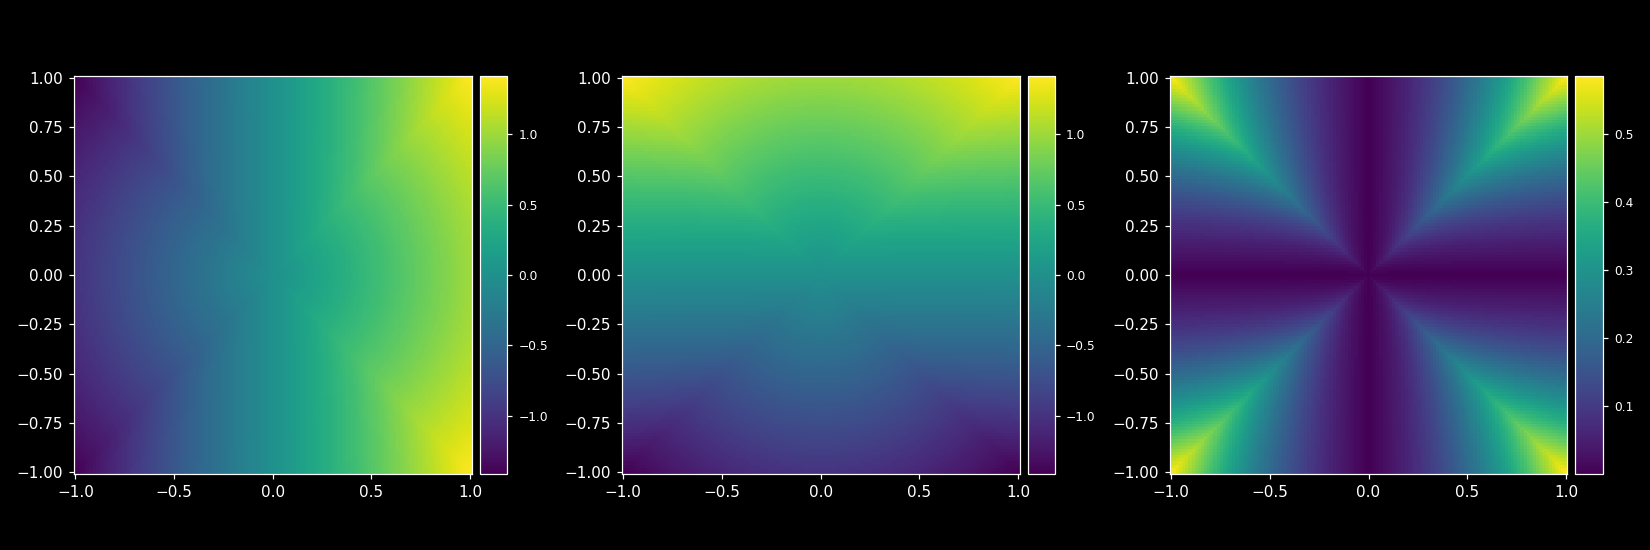

<IPython.core.display.Javascript object>


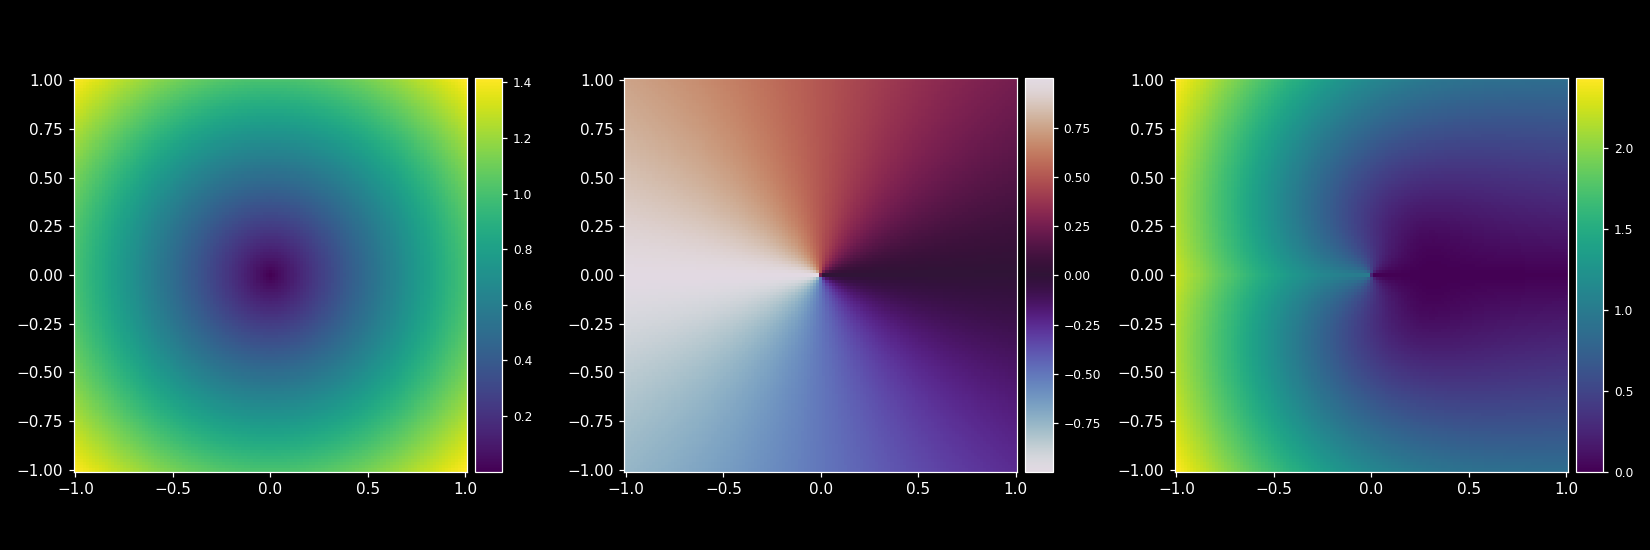

In [44]:

#Eval Mapping
x = torch.linspace(-1,1,127)
y = torch.linspace(-1,1,127)

xx,yy = torch.meshgrid(x,y,indexing='xy')

# debugPrint(xx)

xxf = xx.flatten()
yyf = yy.flatten()

mask = xxf**2 + yyf**2 <= 1
# xxf = xxf[mask]
# yyf = yyf[mask]

positions = torch.hstack((torch.vstack((xxf, yyf)).mT, torch.zeros(xxf.shape[0],1, device = xxf.device, dtype = xxf.dtype)))
cylinderPositions = ballToCylinder(positions)
cubePositions = cylinderToCube(cylinderPositions)

debugPrint(torch.min(cubePositions[mask,0]))
debugPrint(torch.min(cubePositions[mask,1]))
debugPrint(torch.max(cubePositions[mask,0]))
debugPrint(torch.max(cubePositions[mask,1]))


fig, axis = plt.subplots(1, 3, figsize=(15,5), sharex = False, sharey = False, squeeze = False)

# pc = axis[0,0].tripcolor(xxf,yyf, (cubePositions[:,0]))
pc = axis[0,0].pcolormesh(xx,yy, (cubePositions[:,0]).reshape(xx.shape))
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
predCbar = fig.colorbar(pc, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 
axis[0,0].axis('equal')

# pc = axis[0,1].tripcolor(xxf,yyf, (cubePositions[:,1]))
pc = axis[0,1].pcolormesh(xx,yy, (cubePositions[:,1]).reshape(xx.shape))
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
predCbar = fig.colorbar(pc, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 
axis[0,1].axis('equal')

# pc = axis[0,2].tripcolor(xxf,yyf, torch.linalg.norm(positions - cubePositions, dim = 1))
pc = axis[0,2].pcolormesh(xx,yy, (torch.linalg.norm(positions - cubePositions, dim = 1)).reshape(xx.shape))
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
predCbar = fig.colorbar(pc, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 
axis[0,2].axis('equal')

fig.tight_layout()


spherePositions = mapToSpherical(positions)
spherePositions[:,1:] =  spherePositions[:,1:] / np.pi

fig, axis = plt.subplots(1, 3, figsize=(15,5), sharex = False, sharey = False, squeeze = False)

# pc = axis[0,0].tripcolor(xxf,yyf, (cubePositions[:,0]))
pc = axis[0,0].pcolormesh(xx,yy, (spherePositions[:,0]).reshape(xx.shape))
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
predCbar = fig.colorbar(pc, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 
axis[0,0].axis('equal')

# pc = axis[0,1].tripcolor(xxf,yyf, (cubePositions[:,1]))
pc = axis[0,1].pcolormesh(xx,yy, (spherePositions[:,1]).reshape(xx.shape), cmap = cm.twilight)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
predCbar = fig.colorbar(pc, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 
axis[0,1].axis('equal')

# pc = axis[0,1].tripcolor(xxf,yyf, (cubePositions[:,1]))
pc = axis[0,2].pcolormesh(xx,yy, (torch.linalg.norm(positions[:,:2] - spherePositions[:,:2] , dim = 1)).reshape(xx.shape))
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
predCbar = fig.colorbar(pc, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 
axis[0,2].axis('equal')

fig.tight_layout()